In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

import glob
import sys
import os
from collections import OrderedDict

import csv

sys.path.insert(0, "../hcr-ff/")
from plot_utils import *
from genome_utils import *

# General Setup

To start, I'm going to setup a handy utility function to check overlaps.
Then I'm going to start to collect data from the various files generated 
by the analysis pipeline. I'll also bring in some reference data, like 
local gene defs and epigenetics data.

The `*detailed.txt` files contain guide-wise sorting bin counts from our HCR FlowFISH experiments. 

The `FULCO__GATA*_10p.txt` are derived from the Activity-By-Contact (ABC) paper (Fulco et. al. 2019); 
these data are a simplification of the 6-way sorting procedure. We basically decided to only use the 
two extreme expression bins (lowest 10% and highest 10%) and only the first PCR replicate for each 
biological replicate. This makes the ABC paper data compareable to our HCR FlowFISH experiments, and 
allows us compare performance of our peak-caller on similar experiments. We lifted over guide coordinates 
from `GuideInfo.tsv` in the ABC supplement to determine hg38 coordinates, and because strand information was 
not provided by the authors, we had to make the simplifying assumption that all guides are on the positive 
strand.

The `Join_PanGATA*.txt` file is an in-house collation of our experiments and the CRISPRi Growth Screen 
data from Fulco et. al. 2016. It's also lifted over to hg38, but the strand information should be more accurate 
than the `GuideInfo.tsv` liftover.

In [2]:
G1R1_fn = '../data/GATA1_rep5detailed.txt'
G1R2_fn = '../data/GATA1_rep7detailed.txt'

H6R1_fn = '../data/HDAC_rep9detailed.txt'
H6R2_fn = '../data/HDAC_rep10detailed.txt'

ABC1_fn = '../data/FULCO__GATA1_rep1_10p.txt'
ABC2_fn = '../data/FULCO__GATA1_rep2_10p.txt'
ABC3_fn = '../data/FULCO__GATA1_rep3_10p.txt'

FULC_fn = '../data/Join_PanGATA__GATA_CRISPRI_growth___GUIDESCAN_annotated.txt'

fn_list = [G1R1_fn,G1R2_fn,H6R1_fn,H6R2_fn,ABC1_fn,ABC2_fn,ABC3_fn]

exp_ids = ['G1R1','G1R2','H6R1','H6R2','ABC1','ABC2','ABC3','FUL1','FUL2']

fullinfo= [("GATA1",1), ("GATA1",2), ("HDAC6",1), ("HDAC6",2), 
           ("ABC",1), ("ABC",2), ("ABC",3), ("Fulco",1), ("Fulco",2)]

id2info = { exp_id: info for exp_id, info in zip(exp_ids, fullinfo) }

id2info['Ref1'] = ('Growth paper', 1)
id2info['Ref2'] = ('ABC paper', 1)
id2info['k27'] = ('H3K27ac', 1)
id2info['DHS'] = ('DHS', 1)

I'm using a truncated GFF file to specify the genes of interest in the region. TBH, I'm not 100% sure this is actually a GFF, but the table is displayed below so you understand how this file should be formatted if you decide to change it.

In [3]:
gff = pd.read_table('../data/GATA_locus.gff')

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [4]:
gff

,name,chrom,strand,txStart,txEnd,cdsStart,cdsEnd,exonCount,exonStarts,exonEnds,proteinID,transcriptID,geneID
0,ENST00000376670.8,chrX,+,48786553,48794311,48791109,48794164,6,"48786553,48791090,48791843,48792322,48793171,4...","48786645,48791329,48792221,48792468,48793297,4...",P15976,ENST00000376670.8,GATA1
1,ENST00000376619.6,chrX,+,48802033,48824976,48802692,48824612,29,"48802033,48802662,48802870,48803127,48805437,4...","48802170,48802785,48802999,48803216,48805522,4...",Q9UBN7,ENST00000376619.6,HDAC6


### Get guide-wise score info from different experiments

Now I'm going to collect data from each of the guide-wise count files that are compatible with our peak caller. 

I'm going to bring in `log( Low_Expression_Counts / High_Expression_Counts )` as a summary statistic for each rep. This "score" will be high for regions we think are enhancers and low for repressors (either 1st order or otherwise).

In [5]:
data = []
for i, fn in enumerate(fn_list):
    d_pt = pd.read_table(fn,sep='\t',header=0)
    ## Rescale to floats
    rescale = min(d_pt['LS_reads'].sum(),d_pt['HS_reads'].sum()) / d_pt.loc[:,('HS_reads','LS_reads')].sum(axis=0)
    d_pt.loc[:,('HS_reads','LS_reads')] *= rescale
    ## Sample downsized library
    runif              = np.random.uniform(size=d_pt.loc[:,('HS_reads','LS_reads')].shape)
    int_part, sample_p = np.divmod( d_pt.loc[:,('HS_reads','LS_reads')], 1 )
    d_pt.loc[:,('HS_reads','LS_reads')] = int_part + (runif < sample_p)
    ## Return as int
    d_pt.loc[:,('HS_reads','LS_reads')] = d_pt.loc[:,('HS_reads','LS_reads')].astype(int) + 1
    d_pt[exp_ids[i]] = np.log( d_pt['LS_reads'] / d_pt['HS_reads'] )
    data.append( d_pt.loc[((~d_pt['Coordinates'].str.contains("NT")) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-LV2')) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-SgO'))),
                          ('Coordinates',exp_ids[i])] )
    print(d_pt.shape)


/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


(15339, 8)
(15339, 8)
(15339, 8)
(15339, 8)
(19107, 4)
(18595, 4)
(19226, 4)


In [6]:
data = pd.concat([ df.drop_duplicates(subset='Coordinates', keep='first').set_index('Coordinates') for df in data ],axis=1,join='outer',sort=False)

In [7]:
# Flip ABC data
data['ABC1'] = data['ABC1'] * -1
data['ABC2'] = data['ABC2'] * -1
data['ABC3'] = data['ABC3'] * -1

Now I'll append Fulco Growth data.

In [8]:
fulc = pd.read_table(FULC_fn, sep='\t', header=0)
fulc = fulc.loc[ fulc.loc[:,'FulcoCRISPRiGrowth_exo'] == 'FulcoCRISPRiGrowth', 
                 ('Fulco_CRISPRi_Growth_coords', 'Fulco_CRISPRi Score (rep1)', 'Fulco_CRISPRi Score (rep2)') ]
fulc.columns = ["Coordinates","FUL1","FUL2"]
fulc = fulc.set_index("Coordinates")
fulc = fulc.astype(float)
fulc['FUL1'] = fulc['FUL1'] * -1
fulc['FUL2'] = fulc['FUL2'] * -1

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.


In [9]:
data = pd.concat([data, fulc], axis=1, sort=False)

Finally, we'll use the guide coordinates to specify the predicted Cas9 cut-site for each guide. This will allow us to plot guide activity clearly.

In [10]:
data['cutsite'] = [ int(coord.split(':')[1].split('-')[1]) - 4 
                      if coord.split(':')[-1] == '+' 
                      else 
                    int(coord.split(':')[1].split('-')[0]) + 3 
                      for coord in data.index ]

### Get peak calls from different experiments

Now I'm going to walk through the different peak files that we have and collect them into one DataFrame. Here's the rundown:

- `../data/GATA1_rep*__mergedPeaks.bed`    -> HCR-FlowFISH experiment, our analysis
- `../data/HDAC6_rep*__mergedPeaks.bed`    -> HCR-FlowFISH experiment, our analysis
- `../data/ABC_rep*__sigPeaks.bed`         -> Fulco 2019 experiment, our analysis
- `../data/Fulco_GATA_enhancer_filter.bed` -> Peaks we got from Lander lab when we asked for Fulco 2016 peaks
- `../data/ABC_paperPeaks_hg38.bed`        -> Fulco 2019 experiment, significant GATA peaks per their analysis, I lifted over to hg38
- `../data/k27ac_replicatePeaks_hg38_scoreFiltered.bed` -> H3K27ac peaks in hg38 that we cleaned up
- `../data/DNASE_peaks_replicated.bed`     -> DHS peaks in hg38 that we cleaned up

Regarding `Fulco_GATA_enhancer_filter.bed`: These are suspect, the peaks proximal to GATA1 are identical to the ABC paper peaks, though some peaks outside of the locus differ. 

In [11]:
test_peaks = [ pd.read_table(fn,sep='\t',header=None,usecols=[0,1,2],names=['chr','start','end']) for fn in ['../data/GATA1_rep5__mergedPeaks.bed','../data/GATA1_rep7__mergedPeaks.bed'] + ['../data/HDAC_rep9__mergedPeaks.bed','../data/HDAC_rep10__mergedPeaks.bed'] + ['../data/ABC_rep1__sigPeaks.bed','../data/ABC_rep2__sigPeaks.bed','../data/ABC_rep3__sigPeaks.bed'] + ['../data/Fulco_GATA_enhancer_filter.bed','../data/Fulco_GATA_enhancer_filter.bed'] ]
print(len(test_peaks))
extra_feat = [ pd.read_table(fn,sep='\t',header=None,names=['chr','start','end'],usecols=[0,1,2]) for fn in ['../data/Fulco_GATA_enhancer_filter.bed','../data/ABC_paperPeaks_hg38.bed','../data/k27ac_replicatePeaks_hg38_scoreFiltered.bed','../data/DNASE_peaks_replicated.bed'] ]
[ test_peaks.append( feat.loc[ feat['chr'] == 'chrX' ,:] ) for feat in extra_feat ]
test_peaks = [ df.reset_index(drop=True) for df in test_peaks ]
print(len(test_peaks))
for exp_id, peaks_idx in zip(['G1R1','G1R2','H6R1','H6R2','ABC1','ABC2','ABC3','FUL1','FUL2','Ref1','Ref2','k27','DHS'],range(len(test_peaks))):
    test_peaks[peaks_idx]['exp_id'] = exp_id
    test_peaks[peaks_idx]['assay'] = id2info[exp_id][0]
    test_peaks[peaks_idx]['replicate'] = id2info[exp_id][1]
    
test_peaks = pd.concat(test_peaks,axis=0,ignore_index=True)


/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.


9
13


/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
test_peaks = pd.concat([test_peaks,
                        pd.DataFrame([pd.Series(OrderedDict([('chr','chrX'),('start',0),('end',1),('exp_id','FUL1'),('assay','Fulco'),('replicate',1)])),
                                      pd.Series(OrderedDict([('chr','chrX'),('start',0),('end',1),('exp_id','FUL2'),('assay','Fulco'),('replicate',2)]))])
                       ],axis=0,ignore_index=True)


In [13]:
test_peaks

,chr,start,end,exp_id,assay,replicate
0,chrX,48431759,48432159,G1R1,GATA1,1
1,chrX,48546959,48547059,G1R1,GATA1,1
2,chrX,48668359,48668459,G1R1,GATA1,1
3,chrX,48736759,48736859,G1R1,GATA1,1
4,chrX,48782659,48783559,G1R1,GATA1,1
5,chrX,48786159,48787059,G1R1,GATA1,1
6,chrX,48800259,48801259,G1R1,GATA1,1
7,chr12,48782659,48783559,G1R2,GATA1,2
8,chr12,48786159,48787059,G1R2,GATA1,2
9,chr12,48800259,48801159,G1R2,GATA1,2


# Explore the locus

Here we're setting up a plotting function to look all all of the data from each replicate of each experiment that we specify. We're going to plot guide-wise scores at the cutsites and plot peaks on a track above.

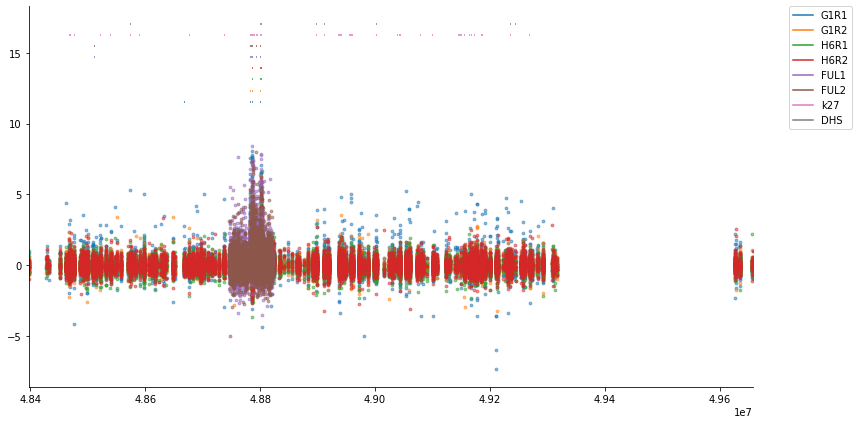

In [14]:
fig_h, ax_h = plot_hff_cutsites(np.array([[48397729,49657309]]), 
          data, test_peaks, plot_ids=['G1R1','G1R2','H6R1','H6R2','FUL1','FUL2','k27','DHS'])


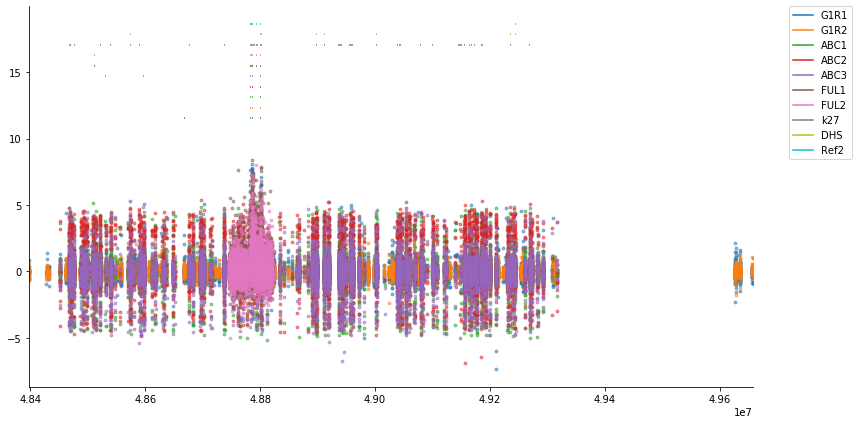

In [15]:
fig_h, ax_h = plot_hff_cutsites(np.array([[48397729,49657309]]), 
          data, test_peaks, plot_ids=['G1R1','G1R2','ABC1','ABC2','ABC3','FUL1','FUL2','k27','DHS','Ref2'])


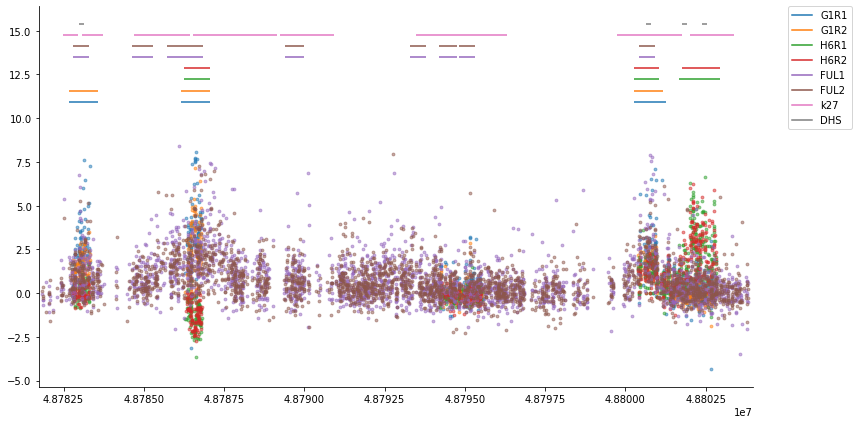

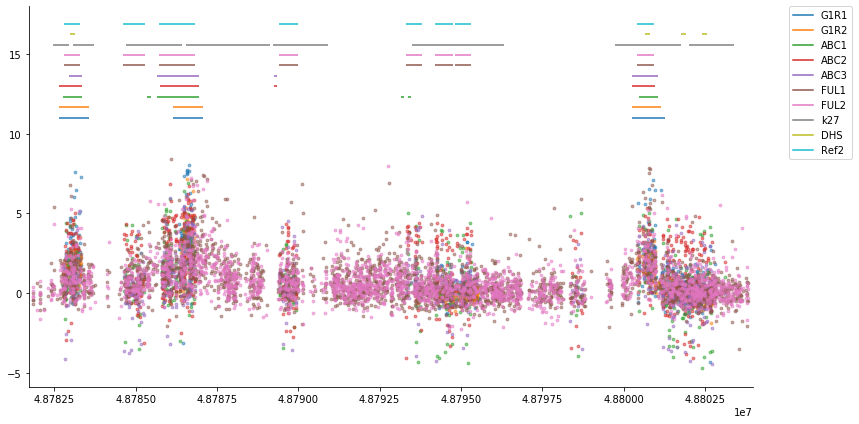

In [16]:
fig_h, ax_h = plot_hff_cutsites(np.array([[48781722,48803966]]), 
          data, test_peaks, plot_ids=['G1R1','G1R2','H6R1','H6R2','FUL1','FUL2','k27','DHS'])

fig_h, ax_h = plot_hff_cutsites(np.array([[48781722,48803966]]), 
          data, test_peaks, plot_ids=['G1R1','G1R2','ABC1','ABC2','ABC3','FUL1','FUL2','k27','DHS','Ref2'])


GATA1
9
HDAC6
11
Fulco
3
GATA1
9
ABC
25


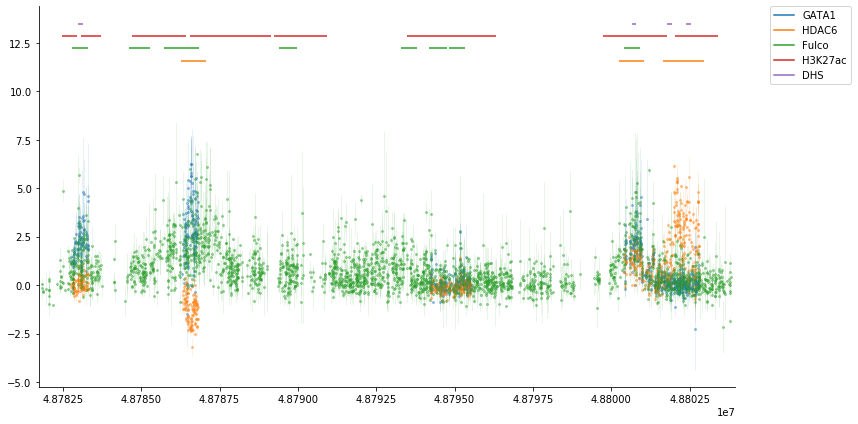

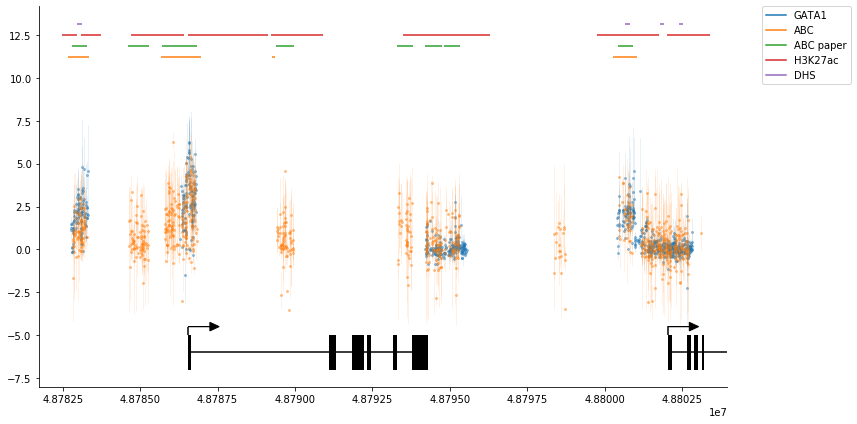

In [17]:
fig_h, ax_h = plot_combined_cutsites(np.array([[48781722,48803966]]), 
                               data, test_peaks, plot_ids=['G1R1','G1R2','H6R1','H6R2','FUL1','FUL2','k27','DHS'])
fig_h.savefig('GATA_locus__48781722_48803966__all.pdf')
fig_h, ax_h = plot_combined_cutsites(np.array([[48781722,48803966]]), 
                               data, test_peaks, plot_ids=['G1R1','G1R2','ABC1','ABC2','ABC3','Ref2','k27','DHS'])
draw_genes_from_gff(ax_h, gff, promoter_params=[700,0.5,300])

fig_h.savefig('GATA_locus_with_ABC__48781722_48803966__all.pdf')


GATA1
180
HDAC6
269
Fulco
4


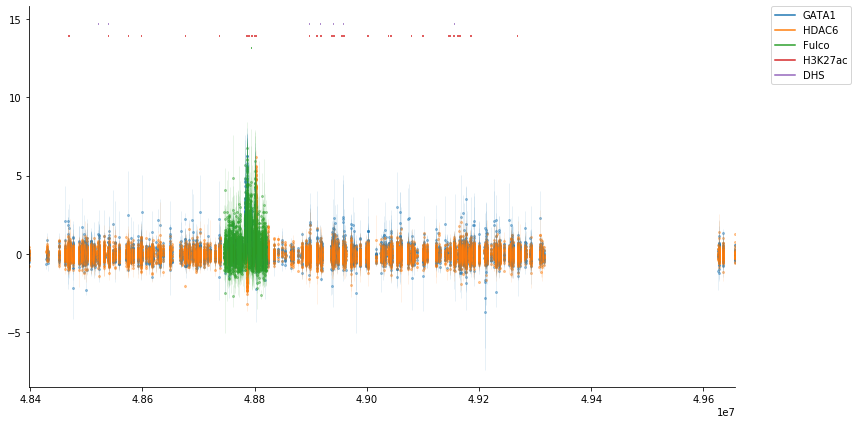

In [18]:
fig_h, ax_h = plot_combined_cutsites(np.array([[48397729,49657309]]), 
                  data, test_peaks, plot_ids=['G1R1','G1R2','H6R1','H6R2','FUL1','FUL2','k27','DHS'])


GATA1
0
HDAC6
1
Fulco
0


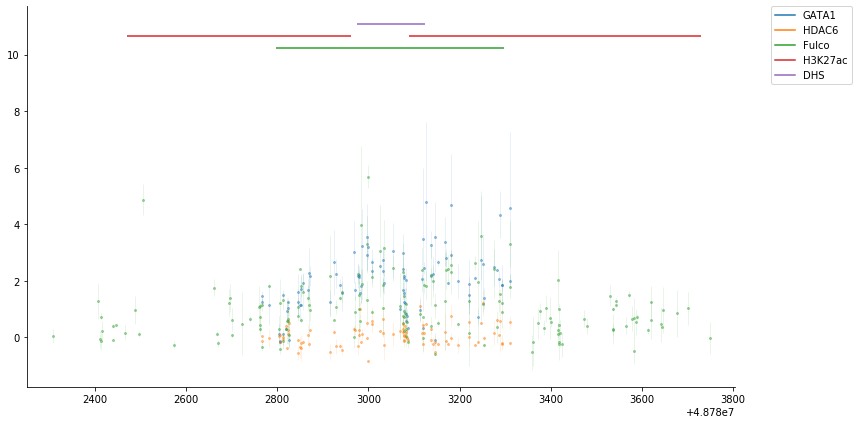

In [19]:
fig_h, ax_h = plot_combined_cutsites(np.array([[48782251,48783805]]), 
                  data, test_peaks, plot_ids=['G1R1','G1R2','H6R1','H6R2','FUL1','FUL2','k27','DHS'])
fig_h.savefig('GATA_locus__48782251_48783805__all.pdf')

GATA1
0
HDAC6
1
Fulco
1


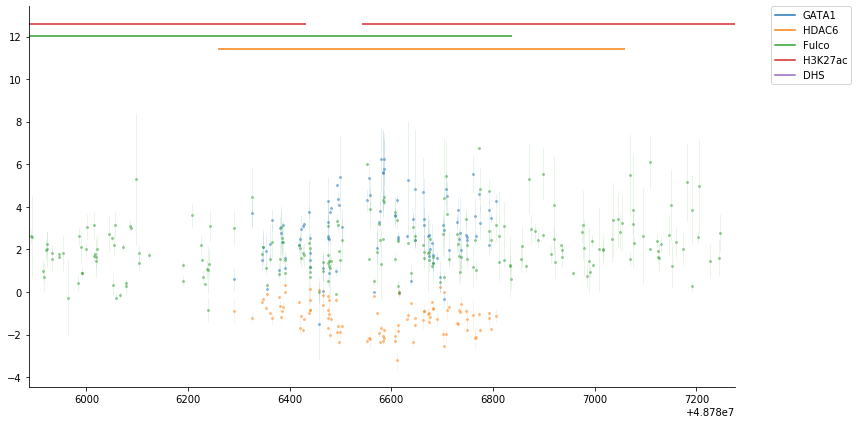

In [20]:
fig_h, ax_h = plot_combined_cutsites(np.array([[48785887,48787277]]), 
                  data, test_peaks, plot_ids=['G1R1','G1R2','H6R1','H6R2','FUL1','FUL2','k27','DHS'])
fig_h.savefig('GATA_locus__48785887_48787277__all.pdf')

GATA1
7
HDAC6
6
Fulco
1


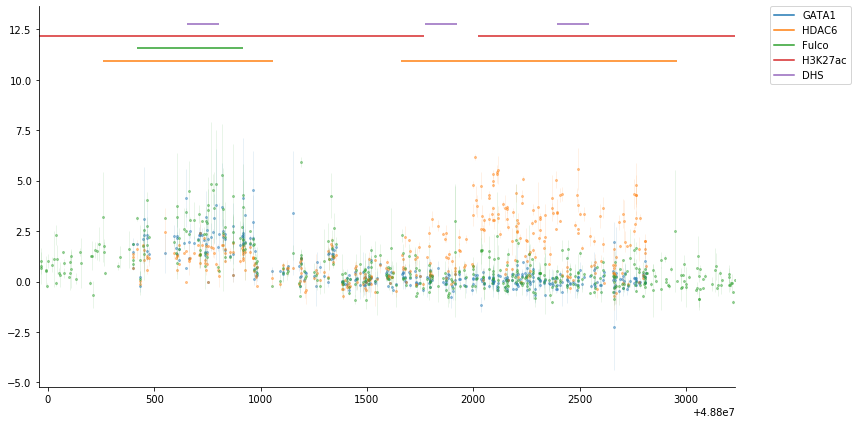

In [21]:
fig_h, ax_h = plot_combined_cutsites(np.array([[48799956,48803233]]), 
                  data, test_peaks, plot_ids=['G1R1','G1R2','H6R1','H6R2','FUL1','FUL2','k27','DHS'])
fig_h.savefig('GATA_locus__48799956_48803233__all.pdf')

GATA1
0
HDAC6
0
Fulco
0
GATA1
0
ABC
4
Fulco
0


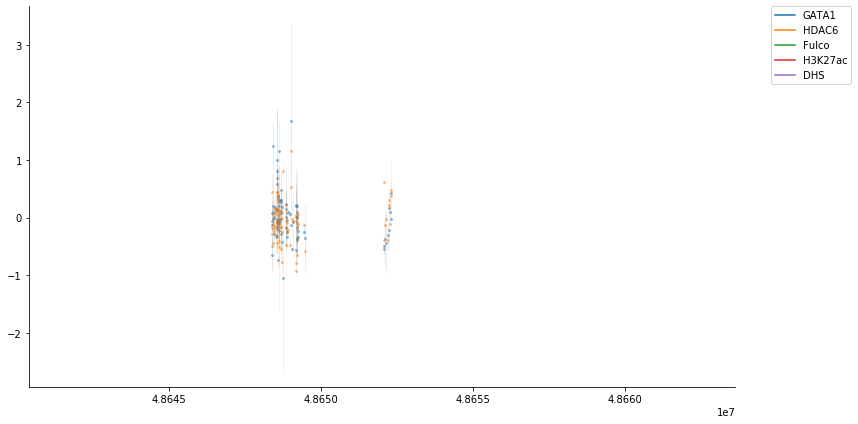

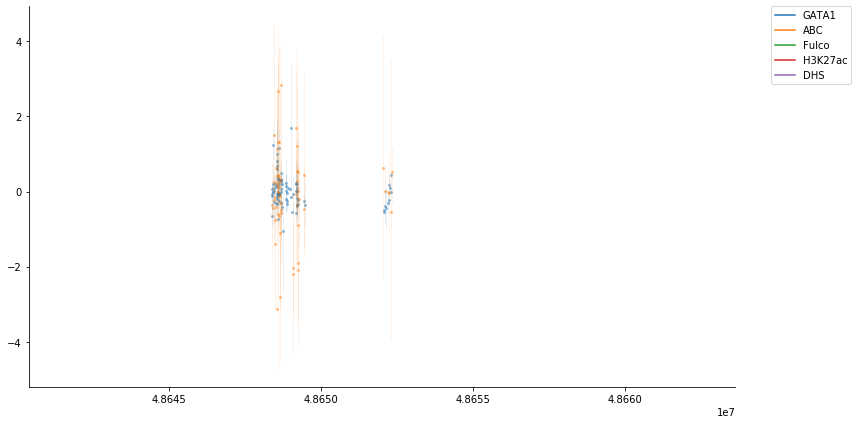

In [22]:
fig_h, ax_h = plot_combined_cutsites(np.array([[48640416,48663623]]), 
                  data, test_peaks, plot_ids=['G1R1','G1R2','H6R1','H6R2','FUL1','FUL2','k27','DHS'])
fig_h.savefig('GATA_locus__48663623_48663623__all.pdf')

fig_h, ax_h = plot_combined_cutsites(np.array([[48640416,48663623]]), 
                  data, test_peaks, plot_ids=['G1R1','G1R2','ABC1','ABC2','ABC3','FUL1','FUL2','k27','DHS'])


GATA1
0
GATA1
0
ABC
4
Fulco
0


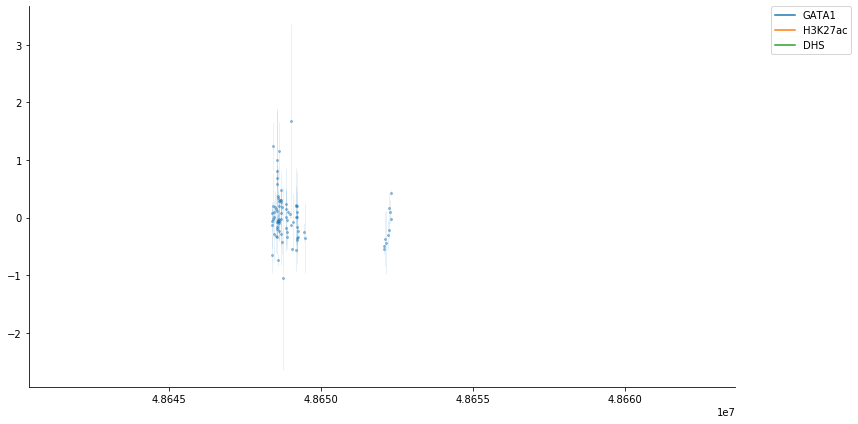

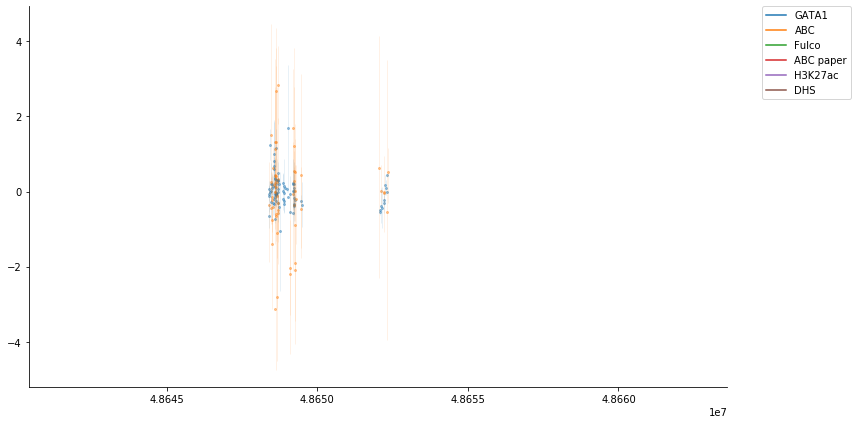

In [23]:
fig_h, ax_h = plot_combined_cutsites(np.array([[48640416,48663623]]), 
                  data, test_peaks, plot_ids=['G1R1','G1R2','k27','DHS'])
fig_h.savefig('GATA_locus__48663623_48663623__all.pdf')

fig_h, ax_h = plot_combined_cutsites(np.array([[48640416,48663623]]), 
                  data, test_peaks, plot_ids=['G1R1','G1R2','ABC1','ABC2','ABC3','FUL1','FUL2','Ref2','k27','DHS'])


### Fulco signal track

In [24]:
targ_data = fulc.loc[ fulc.index != 'NT' ]
plus_offsets = [152, 147]
minus_offsets= [146, 153]
pos_array = np.array([ [ int(coord.split(':')[1].split('-')[1]) - plus_offsets[0],
                         int(coord.split(':')[1].split('-')[1]) + plus_offsets[1] ] if coord.split(':')[2] == '+' 
                       else [ int(coord.split(':')[1].split('-')[1]) - minus_offsets[0],
                              int(coord.split(':')[1].split('-')[1]) + minus_offsets[1] ]
                       for coord in targ_data.index ])

In [25]:
merged_pos = merge_intervals(pos_array)

In [26]:
genome_lims = (np.min(pos_array), np.max(pos_array))
print("{}-{}={}".format(genome_lims[1], genome_lims[0], genome_lims[1] - genome_lims[0]))


48821431-48745125=76306


In [27]:
nt_data = np.zeros( shape=[0, 5] )
last_start    = genome_lims[0]
last_subset = targ_data[ (pos_array[:,0] <= last_start) * (pos_array[:,1] > last_start) ]
ep = 1e-200 # epsilon for stability

for i, segment in enumerate( merged_pos ):
    if i == (merged_pos.shape[0]-1):
        segment[1] += 1
    for j, nt_pos in enumerate( range(*segment) ):
        nt_subset = targ_data[ (pos_array[:,0] <= nt_pos) * (pos_array[:,1] > nt_pos) ]
        if not nt_subset.index.equals(last_subset.index):
            score1 = last_subset[ 'FUL1' ].sum()
            score2 = last_subset[ 'FUL2' ].sum()
            new_entry = np.array([[last_start, last_nt+1, last_subset.shape[0], score1, score2]])
            nt_data = np.concatenate([nt_data,new_entry])
            last_start = nt_pos
        last_subset = nt_subset
        last_nt     = nt_pos
    if i % 20 == 0:
        print("On chunk [{}/{}]".format(i,merged_pos.shape[0]))


On chunk [0/38]
On chunk [20/38]


In [28]:
nt_data = pd.DataFrame(nt_data,columns=["start","stop","guide_count","rep1","rep2"])
nt_data[["start","stop","guide_count"]] = nt_data[["start","stop","guide_count"]].astype(np.int64)

In [29]:
nt_data.to_csv("Fulco_screen__score_track.txt", sep="\t", quoting=csv.QUOTE_NONE, index=False)

# Check metadata features

In [30]:
def get_tidy_table(input_df, data_columns):
    new_columns = [ x for x in input_df.columns if x not in data_columns ]
    new_table   = []
    for data_col in data_columns:
        for line in input_df.iterrows():
            new_line = []
            new_line.append(line[1][data_col])
            new_line.append(data_col)
            for new_col in new_columns:
                new_line.append(line[1][new_col])
            new_table.append(new_line)
        print('Finished {}'.format(data_col),file=sys.stderr)
    return pd.DataFrame(new_table, columns=['obs','obs_type']+new_columns)

In [31]:
fulc_full = pd.read_table(FULC_fn, sep='\t', header=0)

fulc_full['Coordinates'] = [ pg_coord if pg_coord != '.' else ga_coord 
                             for pg_coord, ga_coord 
                             in zip(fulc_full['PanGata_coords'], fulc_full['Fulco_CRISPRi_Growth_coords']) ]

fulc_full = fulc_full.set_index('Coordinates')

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.


In [32]:
data_cp = data.copy()
data_cp = data_cp.assign(specificity=pd.to_numeric(fulc_full['cutting specificity score'],errors='coerce'))
data_cp = data_cp.assign(efficiency=pd.to_numeric(fulc_full['cutting efficiency score'],errors='coerce'))

In [33]:
data_cp['specificity'] = data_cp['specificity'].fillna(value=0.0)
#data_cp = data_cp[ ~data_cp['efficiency'].isna() ]

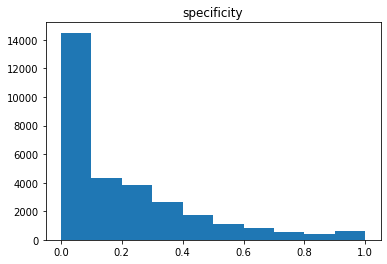

In [34]:
plt.hist(
    data_cp['specificity']
)
plt.title("specificity")
plt.show()

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


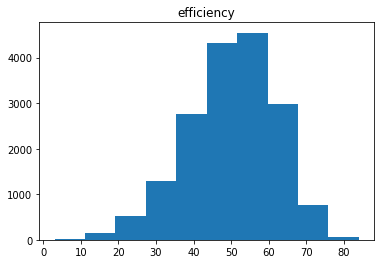

In [35]:
plt.hist(
    data_cp['efficiency']
)
plt.title("efficiency")
plt.show()

In [36]:
spe_bins = np.nanquantile(data_cp[ data_cp['specificity'] > 0.0 ]['specificity'],[0.25,0.5,0.75])
data_cp = data_cp.assign(specificity_bin=np.digitize(data_cp['specificity'],spe_bins))
print(spe_bins)
spe_bins = np.nanquantile(data_cp['efficiency'],[0.25,0.5,0.75])
data_cp = data_cp.assign(efficiency_bin=np.digitize(data_cp['efficiency'],spe_bins))
print(spe_bins)

[0.17146377 0.2766837  0.4505849 ]
[43. 51. 57.]


In [37]:
spe_bins

array([43., 51., 57.])

In [38]:
data_cp = data_cp.reset_index()
data_cp.columns = ['Coordinates']+list(data_cp.columns[1:])

tidy_data = get_tidy_table(data_cp, ['G1R1','G1R2','H6R1','H6R2','FUL1','FUL2','ABC1','ABC2','ABC3'])
tidy_data = tidy_data[ ~tidy_data['obs'].isnull() ]

Finished G1R1
Finished G1R2
Finished H6R1
Finished H6R2
Finished FUL1
Finished FUL2
Finished ABC1
Finished ABC2
Finished ABC3


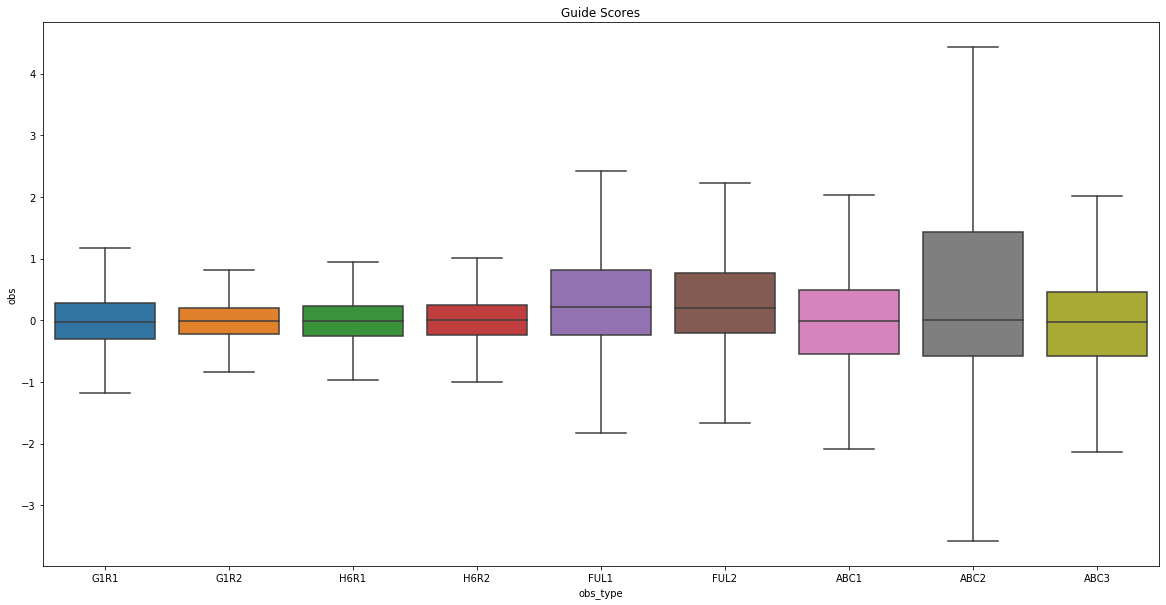

In [39]:
plt.figure(figsize=(20,10))
sns.boxplot(x='obs_type',y='obs',data=tidy_data, showfliers = False) \
  .set_title("Guide Scores");

plt.savefig('marginal_guide_score_distributions.pdf')

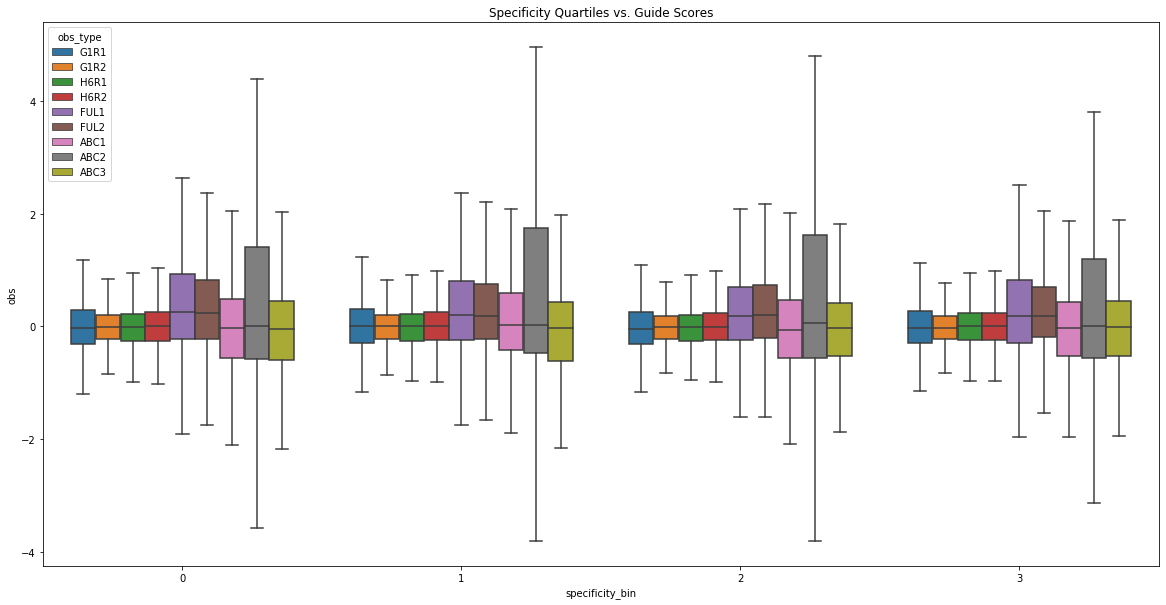

In [40]:
plt.figure(figsize=(20,10))
sns.boxplot(x='specificity_bin',y='obs',hue='obs_type',data=tidy_data, showfliers = False) \
  .set_title("Specificity Quartiles vs. Guide Scores");

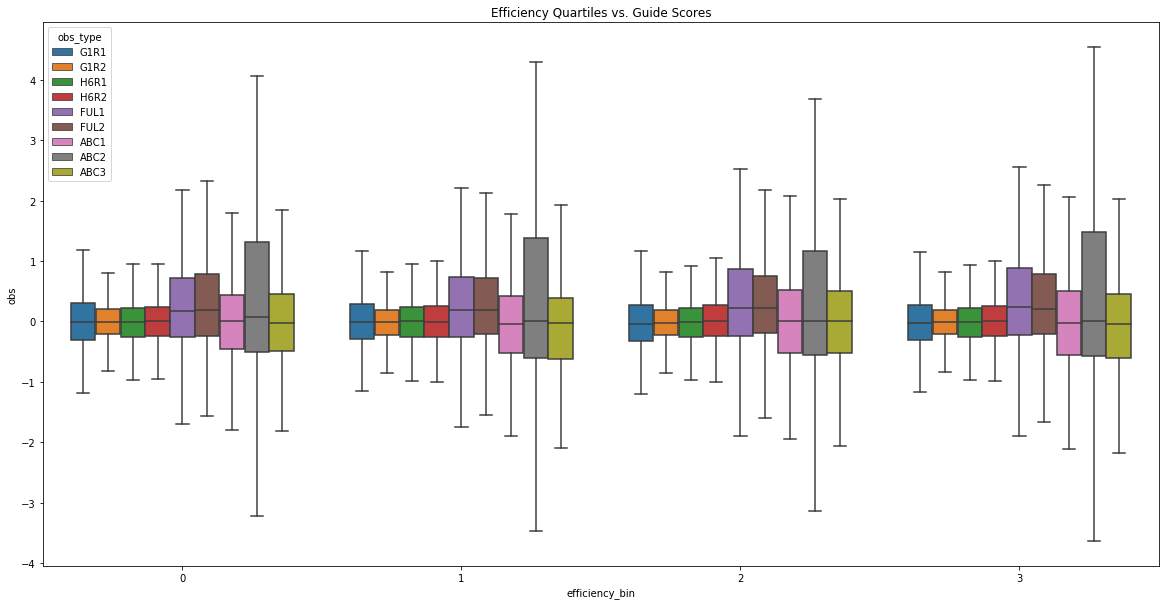

In [41]:
plt.figure(figsize=(20,10))
sns.boxplot(x='efficiency_bin',y='obs',hue='obs_type',data=tidy_data, showfliers = False) \
  .set_title("Efficiency Quartiles vs. Guide Scores");

Text(0.5, 1.0, 'Specificity Quartiles vs. Growth Guide Scores')

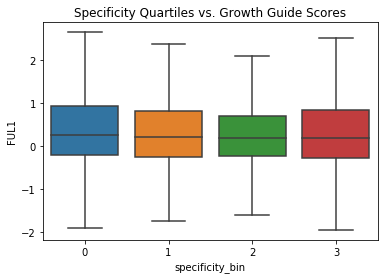

In [42]:
sns.boxplot(x='specificity_bin',y='FUL1',data=data_cp[ ~data_cp['FUL1'].isna() ], showfliers = False) \
   .set_title("Specificity Quartiles vs. Growth Guide Scores")

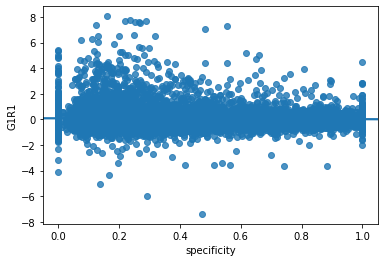

In [43]:
sns.regplot(x='specificity',y='G1R1',data=data_cp[ ~data_cp['G1R1'].isna() ])

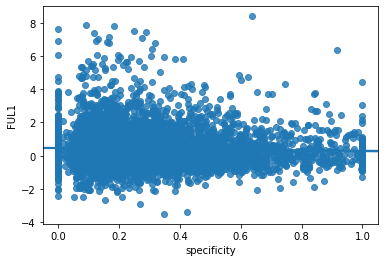

In [44]:
sns.regplot(x='specificity',y='FUL1',data=data_cp[ ~data_cp['FUL1'].isna() ])

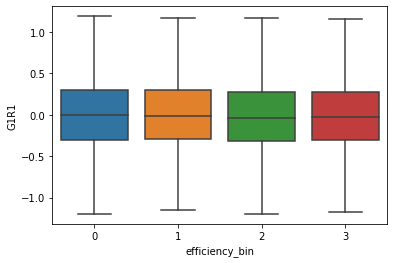

In [45]:
sns.boxplot(x='efficiency_bin',y='G1R1',data=data_cp[ ~data_cp['G1R1'].isna() ], showfliers = False)

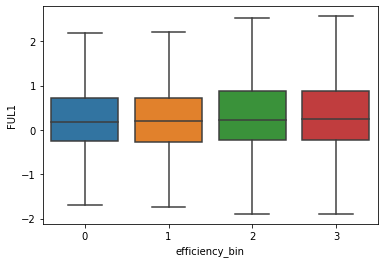

In [46]:
sns.boxplot(x='efficiency_bin',y='FUL1',data=data_cp[ ~data_cp['FUL1'].isna() ], showfliers = False)

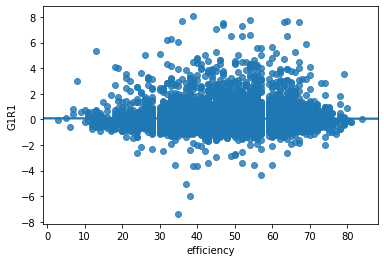

In [47]:
sns.regplot(x='efficiency',y='G1R1',data=data_cp[ ~data_cp['G1R1'].isna() ])

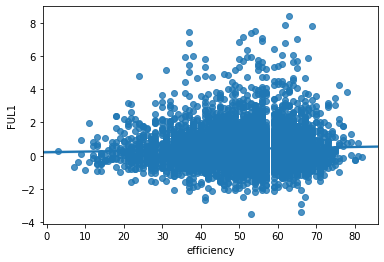

In [48]:
sns.regplot(x='efficiency',y='FUL1',data=data_cp[ ~data_cp['FUL1'].isna() ])

## Filter by Fulco reported Peaks

In [49]:
GATA_filter = pd.read_table('../data/ABC_rep1__sigPeaks.bed',usecols=[0,1,2],names=['chr','start','end'])

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [50]:
tidy_inPeaks = []
for item in tidy_data.iterrows():
    check = sum(check_overlap([item[1]['cutsite'], item[1]['cutsite']+1],
                              GATA_filter.loc[:,('start','end')].values))
    if check > 0:
        tidy_inPeaks.append(item[1])
    if (item[0] + 1) % 50000 == 0:
        print("finished {} rows".format(item[0]+1))

tidy_inPeaks = pd.DataFrame(tidy_inPeaks).reset_index(drop=True)

finished 100000 rows
finished 150000 rows
finished 200000 rows


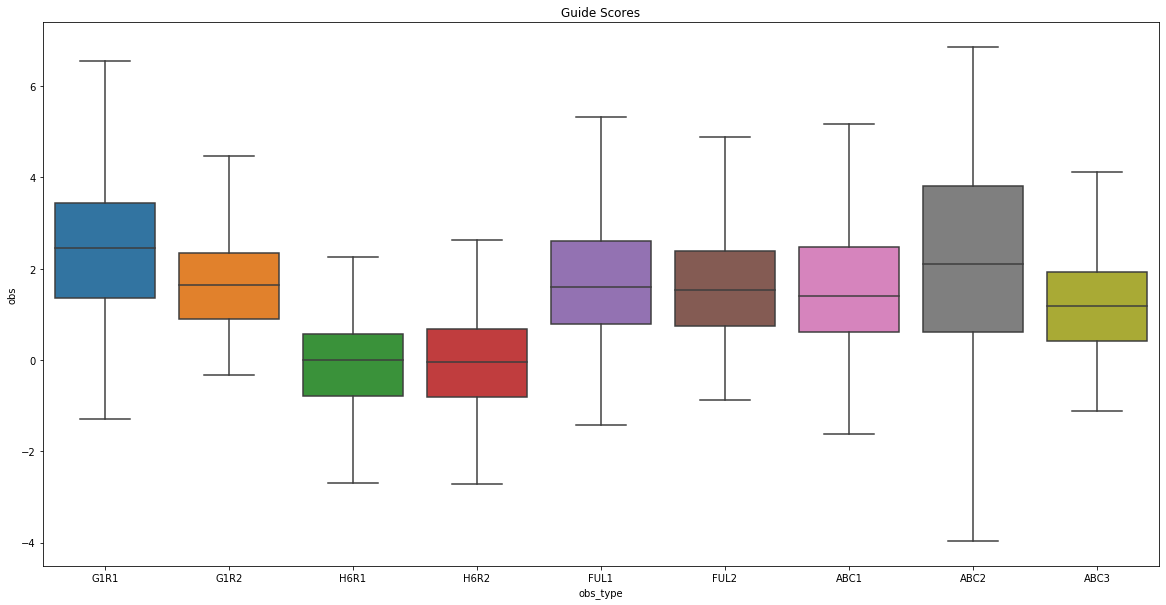

In [51]:
plt.figure(figsize=(20,10))
sns.boxplot(x='obs_type',y='obs',data=tidy_inPeaks, showfliers = False) \
  .set_title("Guide Scores");

plt.savefig('inPeak_guide_score_distributions.pdf')

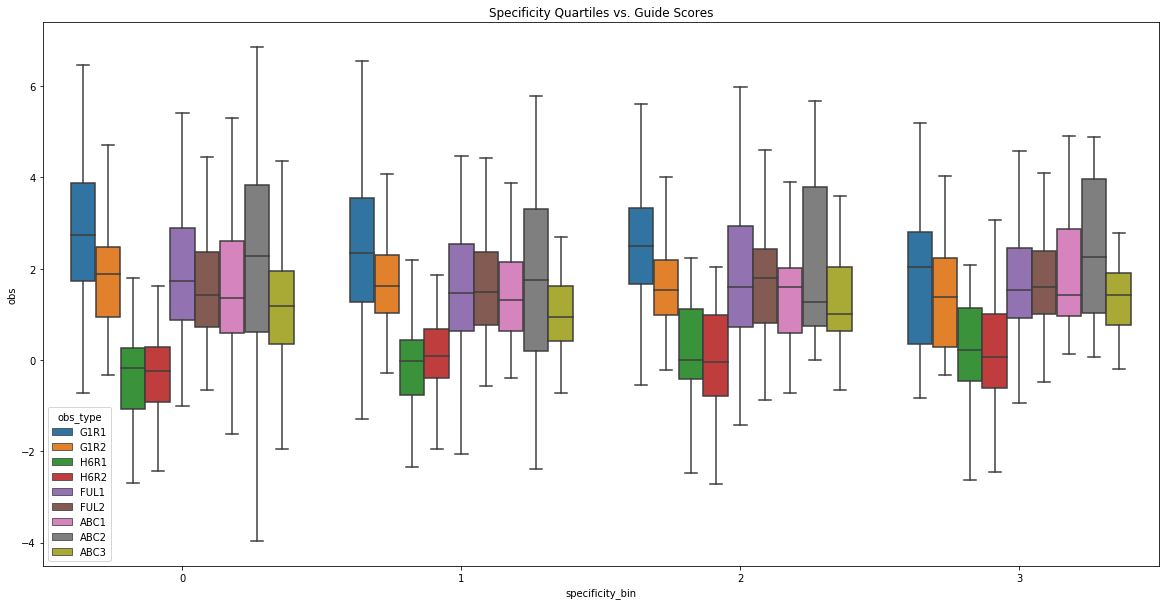

In [52]:
plt.figure(figsize=(20,10))
sns.boxplot(x='specificity_bin',y='obs',hue='obs_type',data=tidy_inPeaks, showfliers = False) \
  .set_title("Specificity Quartiles vs. Guide Scores");

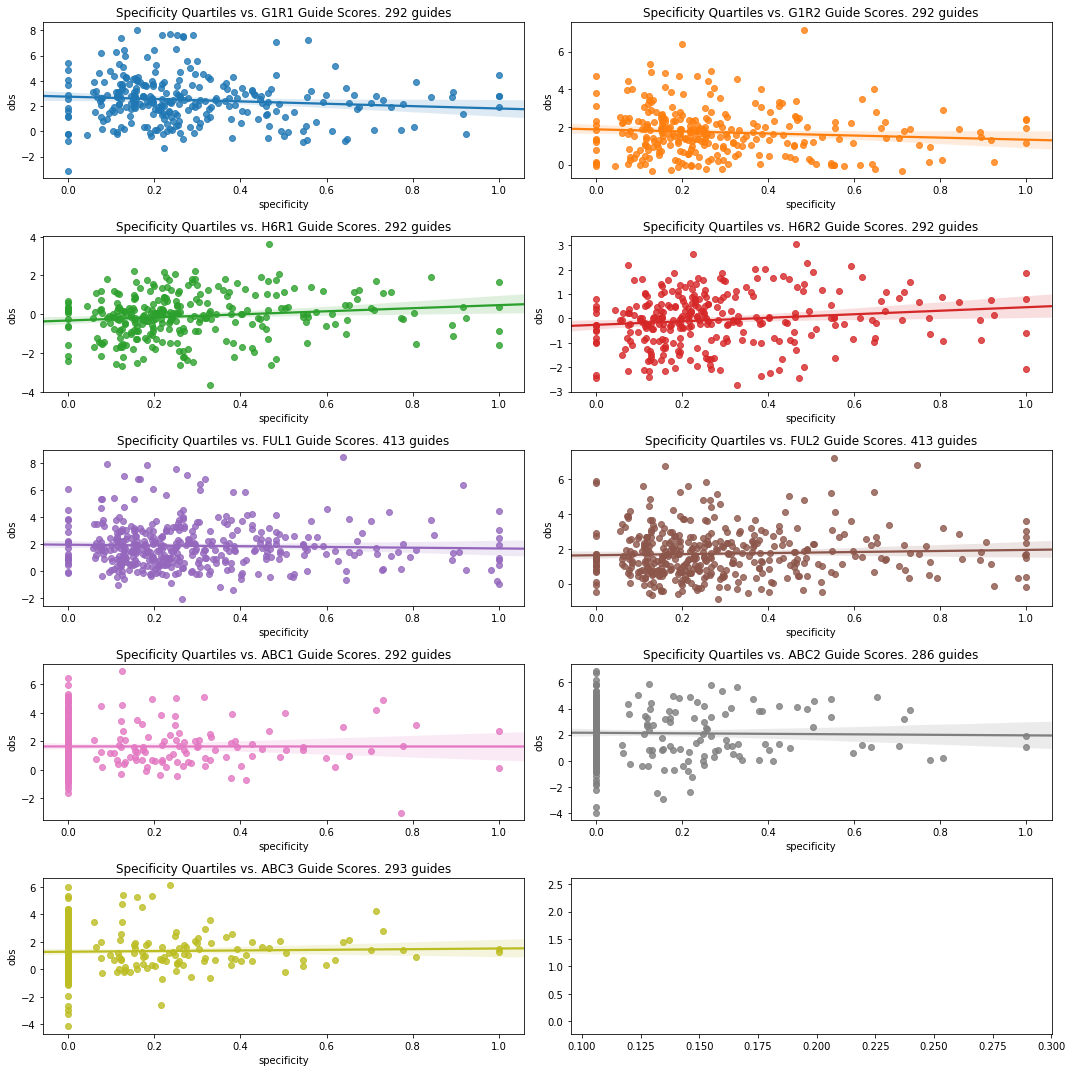

In [53]:
f, axes = plt.subplots(5, 2,figsize=(15,15))
for i,rep_tag in enumerate(['G1R1','G1R2','H6R1','H6R2','FUL1','FUL2','ABC1','ABC2','ABC3']):
    guide_ct = tidy_inPeaks[ tidy_inPeaks['obs_type'] == rep_tag ].shape[0]
    sns.regplot(x='specificity',y='obs',
                data=tidy_inPeaks[ tidy_inPeaks['obs_type'] == rep_tag ],ax=axes[i//2,i%2]) \
      .set_title("Specificity Quartiles vs. {} Guide Scores. {} guides".format(rep_tag, guide_ct))

plt.tight_layout()
plt.show()